In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# Import dependencies
import numpy as np
from cellpose_omni import models, core

# This checks to see if you have set up your GPU properly.
# CPU performance is a lot slower, but not a problem if you 
# are only processing a few images.
use_GPU = core.use_gpu()
print('>>> GPU activated? {}'.format(use_GPU))

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['figure.dpi'] = 300
#plt.style.use('dark_background')
%matplotlib inline

2024-04-29 12:04:52,913 [INFO] ** TORCH GPU version installed and working. **
>>> GPU activated? True


/home/gh464/miniconda3/envs/omnipose_2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tifffile

In [3]:
to_segment = tifffile.imread("to_segment/FL-3.tif")

In [4]:
from cellpose_omni import io, transforms
from omnipose.utils import normalize99
imgs = [fov for fov in to_segment]


nimg = len(imgs)

for k in range(len(imgs)):
    img = transforms.move_min_dim(imgs[k]) # move the channel dimension last
    if len(img.shape)>2:
        # imgs[k] = img[:,:,1] # could pick out a specific channel
        imgs[k] = np.mean(img,axis=-1) # or just turn into grayscale 
        
    imgs[k] = normalize99(imgs[k])
    # imgs[k] = np.pad(imgs[k],10,'edge')


In [5]:
import cellpose_omni
from cellpose_omni import models
from cellpose_omni.models import MODEL_NAMES

MODEL_NAMES

['bact_phase_omni',
 'bact_fluor_omni',
 'worm_omni',
 'worm_bact_omni',
 'worm_high_res_omni',
 'cyto2_omni',
 'plant_omni',
 'bact_phase_cp',
 'bact_fluor_cp',
 'plant_cp',
 'worm_cp',
 'cyto',
 'nuclei',
 'cyto2']

In [6]:
model_name = 'bact_fluor_omni'
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)

2024-04-29 12:04:53,066 [INFO] >>bact_fluor_omni<< model set to be used
2024-04-29 12:04:53,066 [INFO] ** TORCH GPU version installed and working. **
2024-04-29 12:04:53,066 [INFO] >>>> using GPU


In [7]:
import time
chans = [0,0] #this means segment based on first channel, no second channel 

n = [-1] # make a list of integers to select which images you want to segment
n = range(nimg) # or just segment them all 

# define parameters
params = {'channels':chans, # always define this with the model
          'rescale': None, # upscale or downscale your images, None = no rescaling 
          'mask_threshold': -1, # erode or dilate masks with higher or lower values 
          'flow_threshold': 0, # default is .4, but only needed if there are spurious masks to clean up; slows down output
          'transparency': True, # transparency in flow output
          'omni': True, # we can turn off Omnipose mask reconstruction, not advised 
          'cluster': True, # use DBSCAN clustering
          'resample': True, # whether or not to run dynamics on rescaled grid or original grid 
          'verbose': False, # turn on if you want to see more output 
          'tile': False, # average the outputs from flipped (augmented) images; slower, usually not needed 
          'niter': 7, # None lets Omnipose calculate # of Euler iterations (usually <20) but you can tune it for over/under segmentation 
          'augment': False, # Can optionally rotate the image and average outputs, usually not needed 
          'affinity_seg': False, # new feature, stay tuned...
         }

tic = time.time() 
masks, flows, styles = model.eval([imgs[i] for i in n],**params)

net_time = time.time() - tic

print('total segmentation time: {}s'.format(net_time))

2024-04-29 12:05:01,923 [INFO] 100%|##########| 12/12 [00:08<00:00,  1.37it/s]
total segmentation time: 8.743128538131714s


In [8]:
tifffile.imwrite("segmented/bact_fluor_omni.tif", np.array(masks))

In [9]:
from skimage.morphology import binary_dilation
from tqdm.auto import tqdm
from skimage.measure import regionprops_table
from skimage.transform import rotate
from skimage.measure import label
from joblib import Parallel, delayed
from skimage.segmentation import clear_border 

def crop_single_cell(single_cell):
    true_y, true_x = np.where(single_cell)
    
    # Determine the bounding box coordinates
    min_x, max_x = true_x.min(), true_x.max()
    min_y, max_y = true_y.min(), true_y.max()
    
    # Crop the array to the bounding box around the mask
    cropped_single_cell = single_cell[min_y:max_y+1, min_x:max_x+1]
    return np.pad(cropped_single_cell, 1)

In [10]:
def get_single_cell_labels(mask):
    single_cell_labels = []
    mask = clear_border(mask)
    mask_labels = np.unique(mask)[1:]
    for mask_label in (mask_labels):
        dilated_mask = binary_dilation(mask == mask_label)
        if len(np.unique(dilated_mask * mask)) == 2:
            single_cell_labels.append(mask_label)
        else:
            #group_cell_sizes.append(
            #    np.sum(mask == mask_label)
            #)
            pass
    return single_cell_labels
    


In [11]:
def get_single_cell_widths(mask):
    single_cell_labels = get_single_cell_labels(mask)

    widths = []
    for mask_label in single_cell_labels:
        cropped_single_cell = crop_single_cell(mask ==  mask_label) #* 1
        if cropped_single_cell.sum() > 25:
            cell_angle = regionprops_table(label(cropped_single_cell), properties = ["orientation"])["orientation"][0]
            rotation_widths = []
            for rotation_angle in range(361):
                rotated_cell = rotate(cropped_single_cell, rotation_angle, resize=True, order = 0)
                width = rotated_cell[rotated_cell.shape[0]//2-3:rotated_cell.shape[0]//2+3].mean(axis=0).sum()
                rotation_widths.append(width)
            widths.append(np.min(rotation_widths))
    return widths

In [31]:
masks

AttributeError: 'list' object has no attribute 'shape'

In [12]:

widths = Parallel(n_jobs=-1)(delayed(get_single_cell_widths)(mask) for mask in tqdm(masks))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 753.96it/s]


In [13]:
widths = [x for width in widths for x in width]

In [19]:
widths = np.array(widths)*0.11

In [25]:
widths_cropped= widths[np.argwhere(widths < 1.7)]

In [26]:
np.std(widths_cropped)

0.12000726251171448

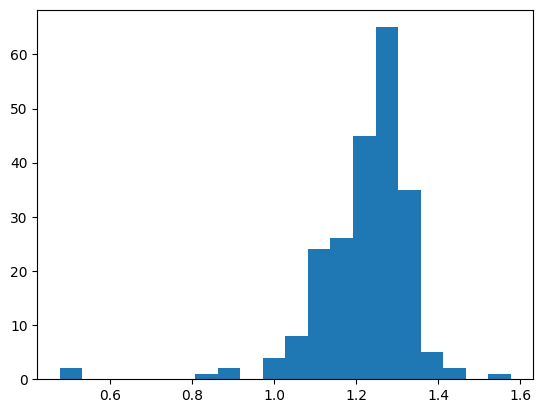

In [27]:
plt.hist(widths_cropped, bins = 20)
plt.show()

In [28]:
np.mean(widths)

1.2335481481481483

Text(0.5, 1.0, 'Default Omnipose')

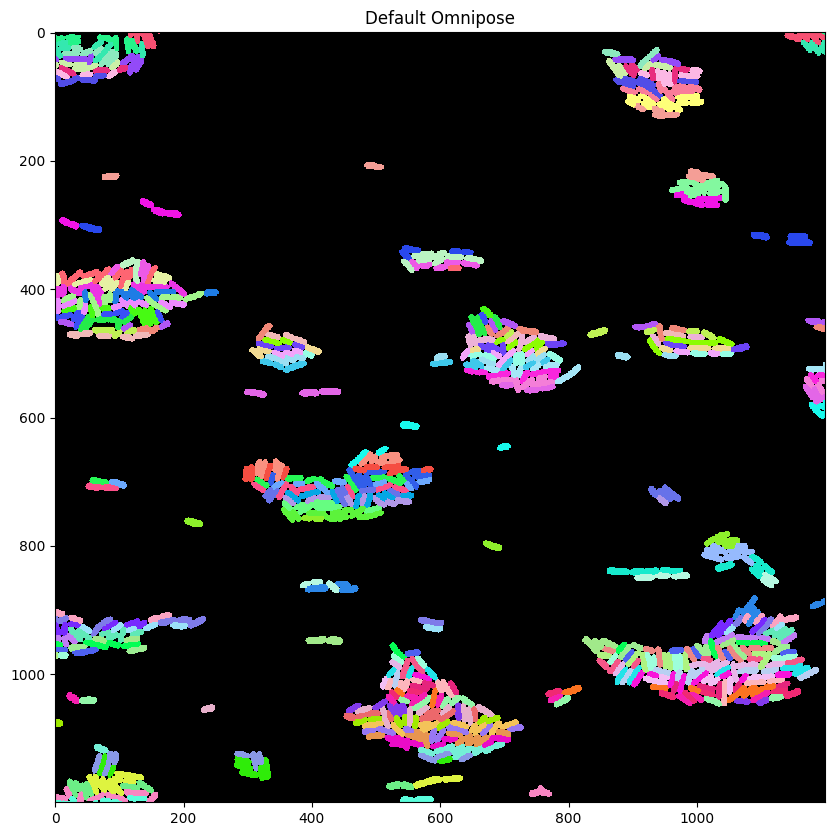

In [29]:
from rand_cmap import rand_cmap
plt.figure(figsize=(10,10))
label_cmap = rand_cmap(100, type='bright', first_color_black=True, last_color_black=False, verbose=False)
plt.imshow(masks[0], cmap = label_cmap, interpolation="nearest")
plt.title("Default Omnipose")